##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/transfer_learning_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Transfer learning with YAMNet for environmental sound classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is a pre-trained deep neural network that can predict audio events from [521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), such as laughter, barking, or a siren. 

 In this tutorial you will learn how to:

- Load and use the YAMNet model for inference.
- Build a new model using the YAMNet embeddings to classify cat and dog sounds.
- Evaluate and export your model.


## Import TensorFlow and other libraries


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [2]:
!pip install -q "tensorflow==2.11.*"
# tensorflow_io 0.28 is compatible with TensorFlow 2.11
!pip install -q "tensorflow_io==0.28.*"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.3 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 3.19.6 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.11.1 which is incompatible.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.11.1 which is incompatible.


In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

## About YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) is a pre-trained neural network that employs the [MobileNetV1](https://arxiv.org/abs/1704.04861) depthwise-separable convolution architecture. It can use an audio waveform as input and make independent predictions for each of the 521 audio events from the [AudioSet](http://g.co/audioset) corpus.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96 second long and extracts one frame every 0.48 seconds .

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as single-channel (mono) 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert WAV files into the supported format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel [spectrogram](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). You can find more details [here](https://tfhub.dev/google/yamnet/1).

One specific use of YAMNet is as a high-level feature extractor - the 1,024-dimensional embedding output. You will use the base (YAMNet) model's input features and feed them into your shallower model consisting of one hidden `tf.keras.layers.Dense` layer. Then, you will train the network on a small amount of data for audio classification _without_ requiring a lot of labeled data and training end-to-end. (This is similar to [transfer learning for image classification with TensorFlow Hub](https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) for more information.)

First, you will test the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use a pre-trained YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL, and use the `load` function.

Note: to read the documentation of the model, use the model URL in your browser.

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

With the model loaded, you can follow the [YAMNet basic usage tutorial](https://www.tensorflow.org/hub/tutorials/yamnet) and download a sample WAV file to run the inference.


In [5]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)


  8192/215546 [>.............................] - ETA: 0s


215546/215546 [==============================] - 0s 0us/step


./test_data/miaow_16k.wav


You will need a function to load audio files, which will also be used later when working with the training data. (Learn more about reading audio files and their labels in [Simple audio recognition](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels).

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in the `[-1.0, 1.0]` range (for more information, go to [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [4]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
            file_contents,
            desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [15]:
import tensorflow as tf
import tensorflow_io as tfio

@tf.function
def load_audio_16k_mono(filename):
    try:
        audio = tfio.audio.decode_mp3(tf.io.read_file(filename))

        sample_rate = tf.cast(44100, dtype=tf.int64) # Default MP3 sample rate. Might not always be true!

        audio = tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)
        # Ensure the audio is float32 and normalized to [-1, 1]
        # audio = tf.cast(audio, tf.float32) / 32768.0

        audio = tf.reduce_mean(audio, axis=1, keepdims=True)
        audio = tf.reshape(audio, [-1]) 
    except:
        audio = None
    return audio

In [89]:
import soundfile as sf

sf.write('output.wav', testing_wav_data_np*32768.0, 16000, subtype='PCM_24') 

In [145]:
print(rf'Sounds\etalons\{i}' for i in os.listdir('Sounds\etalons'))

<generator object <genexpr> at 0x000002BD8A12D620>


In [6]:
filenames = tf.data.Dataset.list_files(r"Sounds\fireworks\converted_*")
dataset = filenames.map(load_audio_16k_mono)

In [5]:
testing_wav_data = (load_audio_16k_mono(r'Sounds\samples\IMG_9658.mp3'))

In [7]:
testing_wav_data = (load_audio_16k_mono(r'Sounds\samples\Chiikawa Usagi.mp3'))

In [6]:
testing_wav_data = (load_audio_16k_mono(r'Sounds\samples\2024-11-19 18-28-18.mp3'))
"""Sounds\samples\2025-01-25 21-21-14.mp3"""

'Sounds\\samples\x825-01-25 21-21-14.mp3'

In [ ]:
# testing_wav_data = load_audio_16k_mono(r'Sounds\etalons\etalons_2.mp3')
testing_wav_data = []
for i in os.listdir(r'Sounds\fireworks'):
    testing_wav_data.append(load_audio_16k_mono(fr'Sounds\fireworks\{i}'))

# _ = plt.plot(testing_wav_data)

# # Play the audio file.
# display.Audio(testing_wav_data, rate=44100)

# _ = plt.plot(testing_wav_data)


# display.Audio(r'Sounds\samples\1408_mixdown.mp3', rate=44100)
# display.Audio(testing_wav_data, rate=22500)

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()` in the CSV format.

In [36]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:]:
    print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
Baby cry, infant cry
Whimper
Wail, moan
Sigh
Singing
Choir
Yodeling
Chant
Mantra
Child singing
Synthetic singing
Rapping
Humming
Groan
Grunt
Whistling
Breathing
Wheeze
Snoring
Gasp
Pant
Snort
Cough
Throat clearing
Sneeze
Sniff
Run
Shuffle
Walk, footsteps
Chewing, mastication
Biting
Gargling
Stomach rumble
Burping, eructation
Hiccup
Fart
Hands
Finger snapping
Clapping
Heart sounds, heartbeat
Heart murmur
Cheering
Applause
Chatter
Crowd
Hubbub, speech noise, speech babble
Children playing
Animal
Domestic animals, pets
Dog
Bark
Yip
Howl
Bow-wow
Growling
Whimper (dog)
Cat
Purr
Meow
Hiss
Caterwaul
Livestock, farm animals, working animals
Horse
Clip-clop
Neigh, whinny
Cattle, bovinae
Moo
Cowbell
Pig
Oink
Goat
Bleat
Sheep
Fowl
Chicken, rooster
Cluck
Crowi

### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.


In [25]:
import subprocess
import os

directory = r'Sounds\other' # Замени на путь к твоей папке

for filename in os.listdir(directory):
    if filename.endswith(".mp3"):
        filepath = os.path.join(directory, filename)
        output_filepath = os.path.join(directory, "converted_" + filename)
        
        command = [
            'ffmpeg', 
            '-i', filepath, 
            '-vn', 
            '-ar', '44100', 
            '-ac', '2', 
            '-ab', '192k', 
            '-f', 'mp3',
            output_filepath
        ]
        
        try:
            subprocess.run(command, check=True, capture_output=True, text=True)
            print(f"File '{filename}' converted successfully.")
        except subprocess.CalledProcessError as e:
            print(f"Error converting '{filename}':")
            print(f"Return code: {e.returncode}")
            print(f"Stdout: {e.stdout}")
            print(f"Stderr: {e.stderr}")


File 'other_0.mp3' converted successfully.
File 'other_1.mp3' converted successfully.
File 'other_10.mp3' converted successfully.
File 'other_100.mp3' converted successfully.
File 'other_101.mp3' converted successfully.
File 'other_102.mp3' converted successfully.
File 'other_103.mp3' converted successfully.
File 'other_104.mp3' converted successfully.
File 'other_105.mp3' converted successfully.
File 'other_106.mp3' converted successfully.
File 'other_107.mp3' converted successfully.
File 'other_108.mp3' converted successfully.
File 'other_109.mp3' converted successfully.
File 'other_11.mp3' converted successfully.
File 'other_110.mp3' converted successfully.
File 'other_111.mp3' converted successfully.
File 'other_112.mp3' converted successfully.
File 'other_113.mp3' converted successfully.
File 'other_114.mp3' converted successfully.
File 'other_115.mp3' converted successfully.
File 'other_116.mp3' converted successfully.
File 'other_117.mp3' converted successfully.
File 'other_118.

In [37]:
for i in dataset:
    if i is not None:
        scores, embeddings, spectrogram = yamnet_model(i)
        class_scores = tf.reduce_mean(scores, axis=0)
        top_class = tf.math.argmax(class_scores)
        inferred_class = class_names[top_class]
    
        print(f'The main sound is: {inferred_class}')
        print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Fireworks
The embeddings shape: (114, 1024)
The main sound is: Silence
The embeddings shape: (5, 1024)
The main sound is: Sound effect
The embeddings shape: (4, 1024)
The main sound is: Sound effect
The embeddings shape: (5, 1024)
The main sound is: Buzz
The embeddings shape: (1, 1024)
The main sound is: Whoosh, swoosh, swish
The embeddings shape: (1, 1024)
The main sound is: Whoosh, swoosh, swish
The embeddings shape: (1, 1024)
The main sound is: Silence
The embeddings shape: (16, 1024)
The main sound is: Music
The embeddings shape: (22, 1024)
The main sound is: Animal
The embeddings shape: (1, 1024)
The main sound is: Fly, housefly
The embeddings shape: (1, 1024)
The main sound is: Animal
The embeddings shape: (1, 1024)
The main sound is: Vehicle
The embeddings shape: (14, 1024)
The main sound is: Silence
The embeddings shape: (151, 1024)
The main sound is: Walk, footsteps
The embeddings shape: (1, 1024)
The main sound is: Eruption
The embeddings shape: (4, 1024)
T

Note: The model correctly inferred an animal sound. Your goal in this tutorial is to increase the model's accuracy for specific classes. Also, notice that the model generated 13 embeddings, 1 per frame.

In [38]:
for i in dataset:
    if i is not None:
        scores, embeddings, spectrogram = yamnet_model(i)
        class_scores = tf.reduce_mean(scores, axis=0)
        top_class = tf.math.argmax(class_scores)
        inferred_class = class_names[top_class]
    
        print(f'The main sound is: {inferred_class}')
        print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Explosion
The embeddings shape: (105, 1024)
The main sound is: Sound effect
The embeddings shape: (4, 1024)
The main sound is: Explosion
The embeddings shape: (55, 1024)
The main sound is: Explosion
The embeddings shape: (14, 1024)
The main sound is: Radio
The embeddings shape: (12, 1024)
The main sound is: Silence
The embeddings shape: (10, 1024)
The main sound is: Fireworks
The embeddings shape: (2, 1024)
The main sound is: Silence
The embeddings shape: (16, 1024)
The main sound is: Music
The embeddings shape: (53, 1024)
The main sound is: Silence
The embeddings shape: (18, 1024)
The main sound is: Slap, smack
The embeddings shape: (1, 1024)
The main sound is: Explosion
The embeddings shape: (8, 1024)
The main sound is: Explosion
The embeddings shape: (16, 1024)
The main sound is: Bell
The embeddings shape: (127, 1024)
The main sound is: Clang
The embeddings shape: (3, 1024)
The main sound is: Boom
The embeddings shape: (11, 1024)
The main sound is: Silence
The emb

In [77]:
import pandas as pd

import os

data = {'filename' : map(lambda x: 'nuke/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/nuke/')))[:100]),
        'category' : 'Выстрелы',
        }

data1 = {'filename' : map(lambda x: 'other/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/other/')))[:100]),
        'category' : 'Другие',
        }

data2 = {'filename' : map(lambda x: 'fireworks/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/fireworks/')))[:100]),
        'category' : 'Фейерверки',
        }

data3 = {'filename' : map(lambda x: 'concatenate/'+x,list(filter(lambda x: x.startswith('converted_'), os.listdir('Sounds/concatenate/')))[:100]),
        'category' : 'Выстрелы',
        }

base_data_path = './Sounds'

def create_folds(df, proportions, random_state):

    if not np.isclose(sum(proportions.values()), 1):
        raise ValueError("Сумма долей должна быть равна 1.")

    np.random.seed(random_state)

    n_rows = len(df)
    folds = []
    start_index = 0
    for value, proportion in proportions.items():
        n_elements = int(round(n_rows * proportion))
        folds.extend([value] * n_elements)
        start_index += n_elements

    if len(folds) < n_rows:
        diff = n_rows - len(folds)
        folds.extend([value]*diff)
    
    np.random.shuffle(folds)

    df['folds'] = folds
    return df

df = pd.DataFrame(data)
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)


proportions = {1: 0.70, 2: 0.20, 3: 0.10}
df = create_folds(df, proportions, random_state=42)
df1 = create_folds(df1, proportions, random_state=42)
df2 = create_folds(df2, proportions, random_state=42)
df3 = create_folds(df3, proportions, random_state=42)

pd_data = pd.concat([df, df1, df2, df3])

In [18]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

FileNotFoundError: [Errno 2] No such file or directory: './datasets/ESC-50-master/meta/esc50.csv'

### Filter the data

Now that the data is stored in the `DataFrame`, apply some transformations:

- Filter out rows and use only the selected classes - `dog` and `cat`. If you want to use any other classes, this is where you can choose them.
- Amend the filename to have the full path. This will make loading easier later.
- Change targets to be within a specific range. In this example, `dog` will remain at `0`, but `cat` will become `1` instead of its original value of `5`.

In [78]:
my_classes = ['Выстрелы', 'Другие', 'Фейерверки']
map_class_to_id = {'Выстрелы':0, 'Другие':1, 'Фейерверки':2}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,category,folds,target
0,./Sounds\nuke/converted_nuke_0.mp3,Выстрелы,2,0
1,./Sounds\nuke/converted_nuke_1.mp3,Выстрелы,1,0
2,./Sounds\nuke/converted_nuke_10.mp3,Выстрелы,2,0
3,./Sounds\nuke/converted_nuke_100.mp3,Выстрелы,1,0
4,./Sounds\nuke/converted_nuke_101.mp3,Выстрелы,1,0
5,./Sounds\nuke/converted_nuke_102.mp3,Выстрелы,1,0
6,./Sounds\nuke/converted_nuke_103.mp3,Выстрелы,1,0
7,./Sounds\nuke/converted_nuke_104.mp3,Выстрелы,2,0
8,./Sounds\nuke/converted_nuke_105.mp3,Выстрелы,1,0
9,./Sounds\nuke/converted_nuke_106.mp3,Выстрелы,1,0


### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the WAV data for the model.

When extracting embeddings from the WAV data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input. Therefore, you need to create a new column that has one frame per row. You also need to expand the labels and the `fold` column to proper reflect these new rows.

The expanded `fold` column keeps the original values. You cannot mix frames because, when performing the splits, you might end up having parts of the same audio on different splits, which would make your validation and test steps less effective.

In [79]:
filtered_pd

,filename,category,folds,target
0,./Sounds\nuke/converted_nuke_0.mp3,Выстрелы,2,0
1,./Sounds\nuke/converted_nuke_1.mp3,Выстрелы,1,0
2,./Sounds\nuke/converted_nuke_10.mp3,Выстрелы,2,0
3,./Sounds\nuke/converted_nuke_100.mp3,Выстрелы,1,0
4,./Sounds\nuke/converted_nuke_101.mp3,Выстрелы,1,0
...,...,...,...,...
95,./Sounds\concatenate/converted_concatenate_108...,Выстрелы,1,0
96,./Sounds\concatenate/converted_concatenate_108...,Выстрелы,2,0
97,./Sounds\concatenate/converted_concatenate_108...,Выстрелы,1,0
98,./Sounds\concatenate/converted_concatenate_108...,Выстрелы,3,0


In [80]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['folds']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [82]:
def load_wav_for_map(filename, label, fold):
    return load_audio_16k_mono(filename), label, fold 

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [84]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

You will use the `fold` column to split the dataset into train, validation and test sets.

ESC-50 is arranged into five uniformly-sized cross-validation `fold`s, such that clips from the same original source are always in the same `fold` - find out more in the [ESC: Dataset for Environmental Sound Classification](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) paper.

The last step is to remove the `fold` column from the dataset since you're not going to use it during training.


In [86]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold == 1)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 2)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 3)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(20).batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)

## Create your model

You did most of the work!
Next, define a very simple [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model with one hidden layer and two outputs to recognize cats and dogs from sounds.


In [87]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input
# from tensorflow.keras.mixed_precision import Policy, set_global_policy
# from tensorflow.keras.metrics import Precision, Recall
# import tensorflow_addons as tfa
# from tensorflow_addons.metrics import F1Score

# f1_metrics = F1Score(num_classes=3, average='macro')

# policy = Policy('mixed_float16')
# set_global_policy(policy)

# my_model = Sequential([
#     Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
#     Dropout(0.5),
#     Dense(512, activation='relu', kernel_regularizer='l1'),
#     Dropout(0.5),
#     Dense(len(my_classes))
# ], name='my_model')

my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                        name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

# print('Compute dtype: ', policy.compute_dtype)
# print('Variable dtype: ', policy.variable_dtype)

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               524800    
                                                                 
 dense_17 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


In [88]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy',
                            ])

# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                             patience=10,
#                                             restore_best_weights=True)

In [89]:
history = my_model.fit(train_ds,
                        epochs=150,
                        validation_data=val_ds,
                        # callbacks=callback
                        )

Epoch 1/150
701/701 [==============================] - 214s 302ms/step - loss: 0.9409 - accuracy: 0.9433 - val_loss: 7.7096 - val_accuracy: 0.1106
Epoch 2/150
701/701 [==============================] - 5s 7ms/step - loss: 0.3743 - accuracy: 0.9451 - val_loss: 10.5599 - val_accuracy: 0.1106
Epoch 3/150
701/701 [==============================] - 5s 7ms/step - loss: 0.4606 - accuracy: 0.9423 - val_loss: 9.6688 - val_accuracy: 0.1106
Epoch 4/150
701/701 [==============================] - 5s 7ms/step - loss: 0.5759 - accuracy: 0.9325 - val_loss: 11.3376 - val_accuracy: 0.1106
Epoch 5/150
701/701 [==============================] - 4s 6ms/step - loss: 0.6986 - accuracy: 0.9315 - val_loss: 12.2481 - val_accuracy: 0.1106
Epoch 6/150
701/701 [==============================] - 4s 6ms/step - loss: 0.7105 - accuracy: 0.9294 - val_loss: 11.3964 - val_accuracy: 0.1106
Epoch 7/150
701/701 [==============================] - 5s 7ms/step - loss: 0.7050 - accuracy: 0.9222 - val_loss: 11.9899 - val_accurac

148/148 [==============================] - 0s 1ms/step


Text(110.44999999999997, 0.5, 'Actual label')

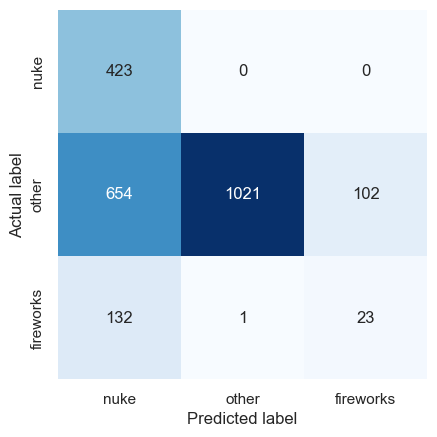

In [261]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = []
for _, y in test_ds:
    y_true.extend(y.numpy())

y_predicted = my_model.predict(test_ds)

class_labels = ['nuke', 'other', 'fireworks']
mat = confusion_matrix(np.array(y_true), np.argmax(y_predicted, axis=1))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Text(113.9222222222222, 0.5, 'Actual label')

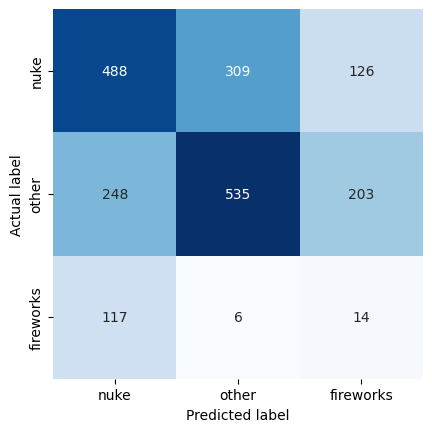

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = []
for _, y in test_ds:
    y_true.extend(y.numpy())

y_predicted = my_model.predict(test_ds)

class_labels = ['Взрывы', 'Другие', 'Фейерверки']
mat = confusion_matrix(np.array(y_true), np.argmax(y_predicted, axis=1))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [276]:
a = list(np.argmax(y_predicted, axis=1))

In [ ]:
a

In [247]:
y_true

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


[]

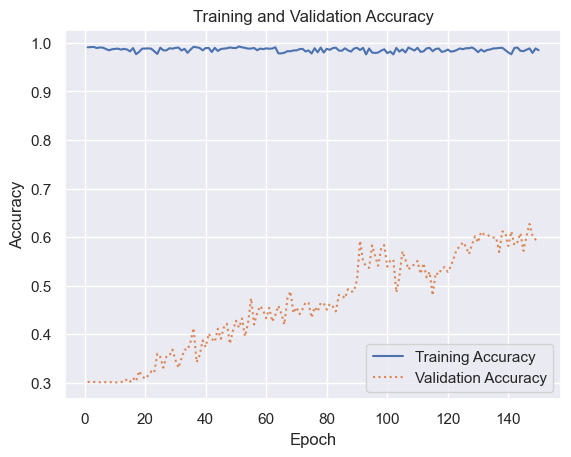

In [262]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Let's run the `evaluate` method on the test data just to be sure there's no overfitting.

In [263]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


148/148 [==============================] - 0s 3ms/step - loss: 13.6964 - accuracy: 0.6227
Loss:  13.696410179138184
Accuracy:  0.622665524482727


You did it!

## Test your model

Next, try your model on the embedding from the previous test using YAMNet only.


In [273]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: nuke


## Save a model that can directly take a WAV file as input

Your model works when you give it the embeddings as input.

In a real-world scenario, you'll want to use audio data as a direct input.

To do that, you will combine YAMNet with your model into a single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving (which you will learn about later in the tutorial), you will need the name of the final layer. If you don't define one, TensorFlow will auto-define an incremental one that makes it hard to test, as it will keep changing every time you train the model. When using a raw TensorFlow operation, you can't assign a name to it. To address this issue, you'll create a custom layer that applies `reduce_mean` and call it `'classifier'`.


In [22]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [23]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet/assets


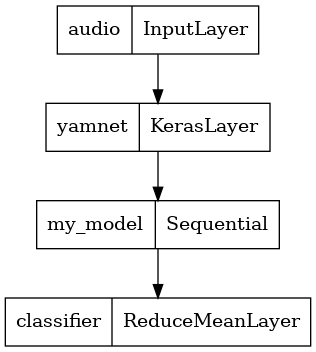

In [24]:
tf.keras.utils.plot_model(serving_model)

Load your saved model to verify that it works as expected.

In [25]:
reloaded_model = tf.saved_model.load(saved_model_path)

And for the final test: given some sound data, does your model return the correct result?

In [26]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


If you want to try your new model on a serving setup, you can use the 'serving_default' signature.

In [27]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


The main sound is: cat


## (Optional) Some more testing

The model is ready.

Let's compare it to YAMNet on the test dataset.

./datasets/ESC-50-master/audio/5-203128-A-0.wav


Waveform values: [-5.1828759e-09  1.5151235e-08 -1.1082188e-08 ...  4.9873297e-03
  5.2141696e-03  4.2495923e-03]


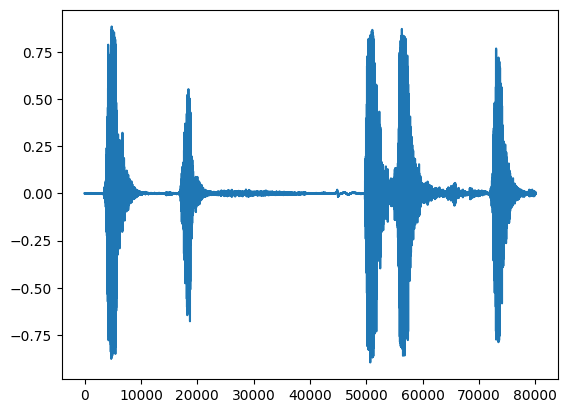

In [28]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [29]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {inferred_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.math.argmax(reloaded_results)
your_inferred_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_inferred_class} ({your_top_score})')

[YAMNet] The main sound is: Animal (0.9544865489006042)


[Your model] The main sound is: dog (0.9998296499252319)


## Next steps

You have created a model that can classify sounds from dogs or cats. With the same idea and a different dataset you can try, for example, building an [acoustic identifier of birds](https://www.kaggle.com/c/birdclef-2021/) based on their singing.

Share your project with the TensorFlow team on social media!
